In [1]:
import random

import numpy as np
import pandas as pd
from sklearn import tree, ensemble
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.inspection import permutation_importance

# Tree Ensembles 

## Assignment overview 

In this assignment you will build two types of tree ensemble models: Random Forest and Boosted. You will then investigate two methods for feature selection. 

###### Outline:


- [Part 1](#part1)- Importing the data set and formatting it 
- [Part 2](#part2)- Fitting a single decision tree
- [Part 3](#part3)- Using a Random Forest Classifier
- [Part 4](#part4)- Using the AdaBoost Classifier
- [Part 5](#part5)- Choosing the best classifier and retraining using all the samples, testing on the test set
- [Part 6](#part6)- Feature selection


[Back to top](#Index:) 

<a id='part1'></a>

### Part 1 - Importing the data set

For this excercise we will be using a data set from the University of Medicine and Pharmacy of Craiova, Romania to predict the hospitalisation period of patients after colon cancer operations based on socio-economic variables and clinical information. You can read more about the data and it's origins [here](https://figshare.com/articles/dataset/LOS_Colon_Cancer_621_cases/4747246/1). 

The data is stored in xlsx format again in the `colon_data.xlsx` file. Use the `read_excel()` function to load it.

In [3]:
df = pd.read_excel('colon_data.xlsx')
len(df)

298

Use the `.head()` function to visulise the data.

In [9]:
df.head(100)

,AGE,SEX,TOPOGRAPHY,STAGE,T,N,M,SURGERY,CLASS
0,64,M,rect,three,T4,Nx,Mx,ten,2
1,70,M,rect,three,T4,Nx,Mx,ten,2
2,76,F,cec,three,T3,Nx,Mx,three,2
3,62,M,cec,three,T2,Nx,Mx,three,1
4,62,M,cec,two,T2,Nx,Mx,three,1
...,...,...,...,...,...,...,...,...,...
95,65,M,colon_trans,one,T1,Nx,Mx,three,1
96,67,M,colon_trans,two,T2,Nx,Mx,three,3
97,71,M,colon_trans,two,T2,Nx,Mx,three,3
98,61,M,colon_trans,one,T1,Nx,Mx,three,1


First we want to replace the categorical values of the output (the `CLASS` variable) with numerical values. Fill in the gaps below to use the `.replace()` function to do this.

In [8]:
df['CLASS'].replace(to_replace='short', value= 1, inplace=True)
df['CLASS'].replace(to_replace='medium', value= 2, inplace=True)
df['CLASS'].replace(to_replace='long', value= 3, inplace=True)

Now use the `get_dummies()` function to transform the other categorical variables to numerical ones. 

In [109]:
test_df = pd.get_dummies(df, dtype=int)
test_df.head()

,AGE,SEX_F,SEX_M,TOPOGRAPHY_cec,TOPOGRAPHY_colon_asc,TOPOGRAPHY_colon_desc,TOPOGRAPHY_colon_sigm,TOPOGRAPHY_colon_trans,TOPOGRAPHY_jonc_rect_sigm,TOPOGRAPHY_rect,...,N_N2,N_Nx,M_M0,M_M1,M_M1_hep,M_Mx,SURGERY_ten,SURGERY_three,SURGERY_two,CLASS
0,64,False,True,False,False,False,False,False,False,True,...,False,True,False,False,False,True,True,False,False,2
1,70,False,True,False,False,False,False,False,False,True,...,False,True,False,False,False,True,True,False,False,2
2,76,True,False,True,False,False,False,False,False,False,...,False,True,False,False,False,True,False,True,False,2
3,62,False,True,True,False,False,False,False,False,False,...,False,True,False,False,False,True,False,True,False,1
4,62,False,True,True,False,False,False,False,False,False,...,False,True,False,False,False,True,False,True,False,1


In [12]:
df = test_df

The following cell is just to ensure the 'CLASS' variable is the last column.

In [13]:
columns = df.columns.to_list()
columns.remove('CLASS')
df = df[columns + ['CLASS']]

We will now process the data similar to how we did for the loan data set activity.

Run the cell below to convert the `df` into a `NumPy` array

In [15]:
Xy=np.array(df)

For reproducibility, set the random seed = 1. You can do this by using the `NumPy` function `random.seed()`. Assign your seed to the variable `seed`. Next, complete the code cell below by using the function `random.shuffle()` on `Xy`.

In [16]:
seed = np.random.seed(1)
random.shuffle(Xy)

Before splitting the data into a training set, a test set, and a validation set, we need to divide `Xy` into two arrays: the first one, `X`, a 2D array containing all the predictors and the second, `y`, a 1D array with the response. 

Run the code cell below to generate `X`. Complete the remaining code to define `y`.

In [18]:
X=Xy[:,:-1]
y=Xy[:,-1]

Next, we need to split the messages into into 50% training data, 25% validation data, and 25% test data.

Run the code below to split `X` and `y` into training, validation and test sets.

In [50]:
trainsize = int(len(df)/2)
trainplusvalsize = int(len(df)/4)
X_train=X[:trainsize].astype('int')
X_val=X[trainsize:trainsize + trainplusvalsize].astype('int')
X_test=X[trainsize + trainplusvalsize:].astype('int')

y_train=y[:trainsize].astype('int')
y_val=y[trainsize:trainsize + trainplusvalsize].astype('int')
y_test=y[trainsize + trainplusvalsize:].astype('int')

[Back to top](#Index:) 

<a id='part2'></a>

### Part 2: Fit a Single Decision Tree 

Use the same code as you used for the loan dataset notebook to fit decision trees with different depths up to `max_depth = 15`. Select the best depth - you will compare this to your tree ensemble methods later. 

In [22]:
df.astype('int').head()

,AGE,SEX_F,SEX_M,TOPOGRAPHY_cec,TOPOGRAPHY_colon_asc,TOPOGRAPHY_colon_desc,TOPOGRAPHY_colon_sigm,TOPOGRAPHY_colon_trans,TOPOGRAPHY_jonc_rect_sigm,TOPOGRAPHY_rect,...,N_N2,N_Nx,M_M0,M_M1,M_M1_hep,M_Mx,SURGERY_ten,SURGERY_three,SURGERY_two,CLASS
0,64,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,1,1,0,0,2
1,70,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,1,1,0,0,2
2,76,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,2
3,62,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
4,62,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1


In [71]:
max_depth = 15
bestdepth=-1
bestscore = 0

for i in range(15):
    clf = tree.DecisionTreeClassifier(max_depth=i+1)
    #fit the training sets
    clf.fit(X_train, y_train)
    #update trainscore
    trainscore=clf.score(X_train, y_train)
    #update valscore
    valscore=clf.score(X_val, y_val)
    print( 'Depth:', i+1, 'Train Score:', trainscore, 'Validation Score:', valscore)
    if valscore>bestscore:
        #update bestscore
        bestscore=valscore
        #update depth
        bestdepth=i+1
print(bestdepth, bestscore)

Depth: 1 Train Score: 0.5838926174496645 Validation Score: 0.7432432432432432
Depth: 2 Train Score: 0.6510067114093959 Validation Score: 0.2702702702702703
Depth: 3 Train Score: 0.7114093959731543 Validation Score: 0.40540540540540543
Depth: 4 Train Score: 0.7718120805369127 Validation Score: 0.7027027027027027
Depth: 5 Train Score: 0.8322147651006712 Validation Score: 0.7162162162162162
Depth: 6 Train Score: 0.8859060402684564 Validation Score: 0.7027027027027027
Depth: 7 Train Score: 0.8993288590604027 Validation Score: 0.6891891891891891
Depth: 8 Train Score: 0.9328859060402684 Validation Score: 0.7027027027027027
Depth: 9 Train Score: 0.9530201342281879 Validation Score: 0.7297297297297297
Depth: 10 Train Score: 0.9798657718120806 Validation Score: 0.7027027027027027
Depth: 11 Train Score: 0.9798657718120806 Validation Score: 0.7162162162162162
Depth: 12 Train Score: 0.9932885906040269 Validation Score: 0.6891891891891891
Depth: 13 Train Score: 0.9932885906040269 Validation Score: 

In [28]:
print(bestdepth, bestscore)

1 0.7432432432432432


***Question***

What is the best maximum depth? 


1


[Back to top](#Index:) 

<a id='part3'></a>

## Part 3: Random Forest

In this section you will learn how to build a random forest model in sklearn and explore the effect of the `max_features` hyperparameter. 

Use the `ensemble.RandomForestClassifier()` function to build a random forest model with the default parameters. Use the `.fit()` function to train it, the same as you did for the decision tree. 

In [53]:
rf_clf = ensemble.RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [70]:
print ( 'Full tree guess train/validation ',rf_clf.score(X_train, y_train),rf_clf.score(X_val, y_val))

Full tree guess train/validation  0.9932885906040269 0.7297297297297297


In random forest classifiers, the algorithm only considers a subset of the features at each split. This is controlled using the `max_features` argument. Normally this subset size is set to the square root of the total number of features, but here we will look at both setting it to the square root `"sqrt"` (this is the default in sklearn) and to `None`. when `max_features = None` the algorithm is using all the features at every split. 


In [69]:
# for loop looking at RF with different max_features 

np.random.seed(1)
for max_features in ["sqrt",  None]:
    # build the rf classifier with different arguments for max_features
    #fit to the training data
    rf_clf = ensemble.RandomForestClassifier(max_features=max_features)
    rf_clf.fit(X_train, y_train)
    
    print ( f'Full tree guess train/validation {max_features}',rf_clf.score(X_train, y_train),rf_clf.score(X_val, y_val))


Full tree guess train/validation sqrt 0.9932885906040269 0.7162162162162162
Full tree guess train/validation None 0.9932885906040269 0.7297297297297297


***Question***

Which method performs best? Why might this be?

Both perform the same on the training set. 'None' performs better on the validation set.

Rerun the cell above with different random seeds (but remember to set it back to `random_seed=1`). What happens? Why is this? 

'None' usually performs better. This may be due to some of the features being withheld at each decision point being important features. The correlation between some of the features may also play a part in this

[Back to top](#Index:) 

<a id='part4'></a>

## Part 4: Boosting

For our boosting algorithm we will use scikit learn's AdaBoost. This boosting algorithm works by building an ensemble of weak classifiers (in our case decision trees) by sequentially weighting the incorrectly classified instances. 



Use the .AdaBoostClassifier() to build a boosting model and fit it to the training data.

In [67]:
ab_clf = ensemble.AdaBoostClassifier()
ab_clf.fit(X_train, y_train)

AdaBoostClassifier()

In [68]:
print ( 'Full tree guess train/validation ',ab_clf.score(X_train, y_train),ab_clf.score(X_val, y_val))

Full tree guess train/validation  0.6308724832214765 0.581081081081081


[Back to top](#Index:) 

<a id='part5'></a>

## Part 5: Model Selection

***Question***

Which model would you use for this dataset? Decision tree, Random Forest or Boosting? Why? 

I would use the random forest as the performance to a decision tree on the validation set is very similar and the variance _should_ be lower. The performance on the test set is also much higher. The boosting tree does not have good performance. 

I would use a random forest with no max features.


Retrain the best model with both the training and validation data and test it on the test data.

In [99]:
X_trainval=X[:trainplusvalsize,:].astype('int')
y_trainval = y[:trainplusvalsize ].astype('int')
np.random.seed(1)
best_clf = ensemble.RandomForestClassifier(max_features=None)
best_clf.fit(X_trainval, y_trainval)

print ( 'Full tree guess train/validation ',best_clf.score(X_trainval, y_trainval),best_clf.score(X_test, y_test))

Full tree guess train/validation  0.9864864864864865 0.8933333333333333


[Back to top](#Index:) 

<a id='part6'></a>

# Part 6: Feature Selection

Feature selection can help us understand our model and the outputs it gives us, as well as remove any irrelevant predictors. In this section we will be looking at how to identify the most important features in a decision tree using two different methods:
- Impurity metric approaches
- Permutation Importances 

We will be looking at feature selection for your best model (`best_clf`)

Use the `.feature_importances_` function to get the inbuilt impurity metric measure. Then use the `.argsort()` 
function to sort the resulting feature importances. 



In [112]:
feature_importances = best_clf.feature_importances_
sorted_idx = np.argsort(feature_importances).astype('int')

In [106]:
feature_importances

array([0.19911496, 0.01003055, 0.01136946, 0.05115118, 0.20960148,
       0.        , 0.        , 0.        , 0.        , 0.00309814,
       0.        , 0.00127932, 0.03131547, 0.02581406, 0.00785839,
       0.02513741, 0.15195797, 0.08457824, 0.02204734, 0.00078421,
       0.01047628, 0.0092187 , 0.13071445, 0.00174782, 0.00109449,
       0.        , 0.00685327, 0.00229203, 0.00246479, 0.        ])

Get the feature names from the dataframe columns `.columns`. Remember to remove the last column from the list as this is the output column.

In [117]:
feature_names = np.array(columns)

In [118]:
type(feature_names)

numpy.ndarray

Use the function below to plot the importances.

In [110]:
def plot_impurity_metric_features( feature_importances, sorted_idx, feature_names):
    y_ticks = np.arange(0, len(feature_names))
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.barh(y_ticks, feature_importances[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_title("Random Forest Feature Importances")
    fig.tight_layout()
    plt.show()



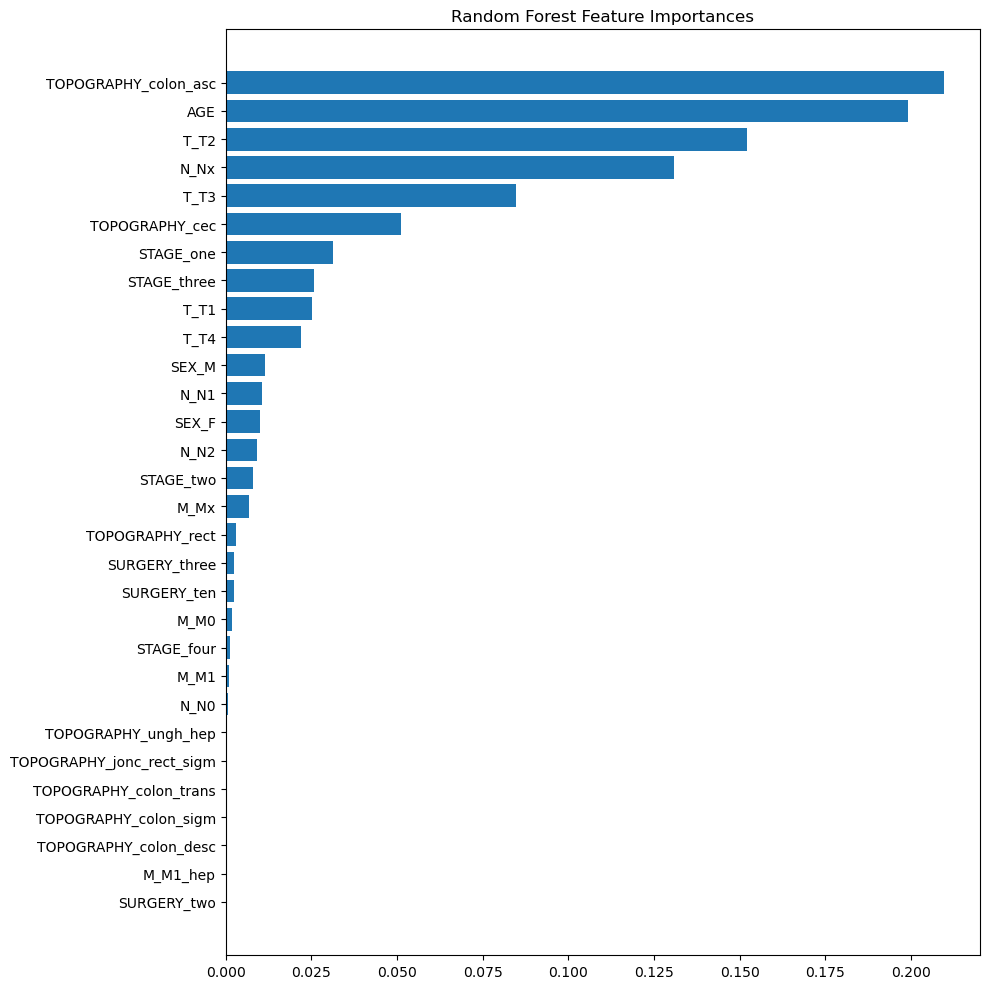

In [120]:
# plot the impurity metric feature importances 
plot_impurity_metric_features(feature_importances, sorted_idx, feature_names)


***Question***

What are the 3 most important features? 

TYPOGRAPHY_colon_asc, AGE, T_T2


One of the downsides of the inbuilt impurity metric is that it can only be applied to training data. This doesn't give us any indication of which features will be the most important on unseen data. 

Instead, we can use the permutation importance to measure the feature importances on both the training and validation sets. 

Complete the `permutation_importance` function to calculate the importance of the diffierent features in the training dataset. Then use the `argsort()` to sort the features in order of importance again.

In [129]:
# permutation method on both training and test


result = permutation_importance(estimator= best_clf, X= X_train, y= y_train, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = np.argsort(result.importances_mean)



Use the function below to plot the permutation importances.

In [130]:
sorted_idx

array([ 3, 14, 27, 26, 25, 24, 23, 21, 20, 19, 28, 29,  8, 10,  9, 11,  7,
        2,  6,  5, 15,  1, 18, 17, 13, 12,  0, 22,  4, 16])

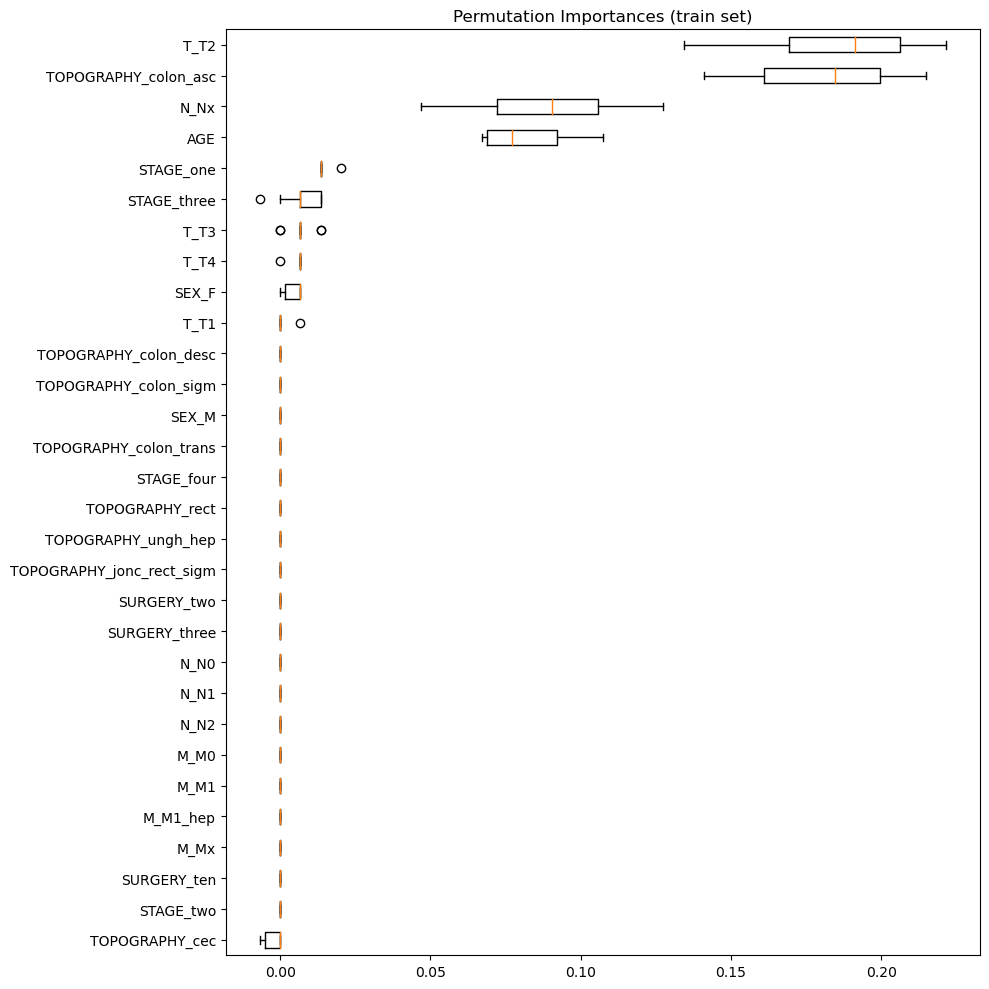

In [131]:

def plot_perm_importance(result, sorted_idx, feature_names):

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.boxplot(
        result.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx]
    )
    ax.set_title("Permutation Importances (train set)")
    fig.tight_layout()
    plt.show()
    
plot_perm_importance(result, sorted_idx, feature_names)


What do you notice about the difference between the two methods of doing feature selection? Why do you think this is?

The importance of age dropped considerable and T_T2 rose to the top. I think this is because age is highly correlated with other features, which lead to permutations having a harsher impact on the importance.


Now calculate the permutation importance on the test set. 

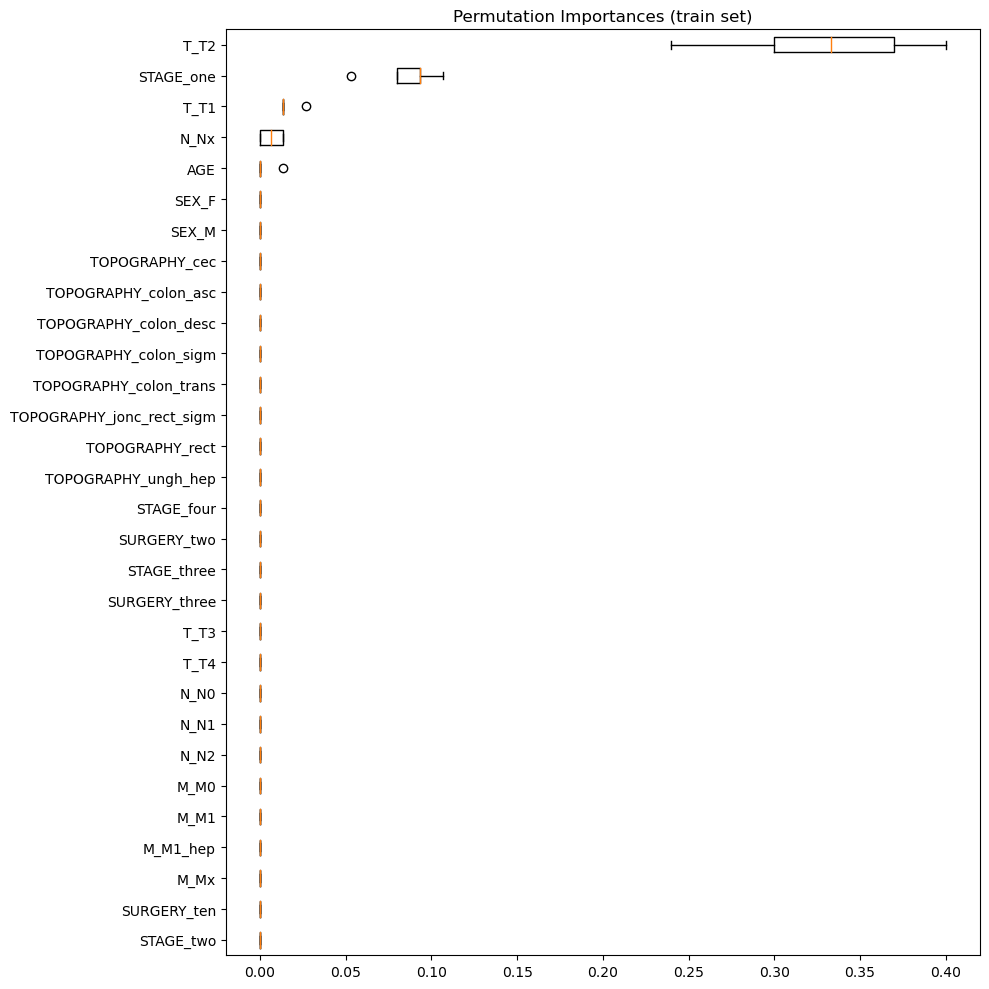

In [132]:
result = permutation_importance(estimator= best_clf, X= X_test, y= y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = np.argsort(result.importances_mean)

plot_perm_importance(result, sorted_idx, feature_names)

What do you see in the test data?

Why do some of the importances go negative?

(3 marks)

The test data has very few important features, age of which being the main one.

Negative importance occurs when it is found that removing the feature would actually improve the performance of the model.